# 2024-09-30 Asl RFP Polo GFP analysis

**Purpose:** Man I'm running fast. I am taking line scans of PoloGFP and AslRFP in interphase cells from WT and PP4KO cells. I did this by finding an interphase frame and then sum-projecting that timepoint to make one image, which I then traced ~7um long lines to do linescans on. 

Here, I want to normalize the line distance (x axis parameter) and intensity measurements for each channel (y axis parameter). I then want to do some plotting to see if I can visualize the difference in PP4KO cells. 

Additionally, I will try to perform overlapping area under the curve measurements. 

In [1]:
# Loading in standard libraries and functions

### --- REMOVE PRINT FUNCTION: --- ### 

# Makes it so any variable or statement on it's own line gets printed w/o print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

### --- IMPORT LIBRARIES: --- ###

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
#import altair as alt
import os
import glob
import matplotlib.patches as mpatches
# We're also going to tell Jupyter to use inline plotting instead of notebook plotting
# It basically means you don't have to use plt.show() in every cell
%matplotlib inline
import re

### --- CONJ 510 SUMMARY TABLES: --- ### 

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

#summary = fil.groupby('condition').agg(['mean', 'std', 'min', 'max', 'median', percentile(25), percentile(75), 'skew'])
#summary

### --- IMPORT SCIPY T TEST: --- ###

from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
from scipy.stats import t

### --- IND. T-TEST FUNCTION: --- ###
# source: https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/

def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = mean(data1), mean(data2)
    # calculate standard errors
    se1, se2 = sem(data1), sem(data2)
    # standard error on the difference between the samples
    sed = sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

### --- 3D CARTESIAN DISTANCE FUNCTION: --- ###

# AB = sqrt((x2 - x1)^2  +   (y2 - y1)^2   +   (z2 - z1)^2)

def cart3D_dist(x1, x2, y1, y2, z1, z2):
    x_dif = x2-x1
    y_dif = y2-y1
    z_dif = z2-z1
    x_sqr = x_dif**2
    y_sqr = y_dif**2
    z_sqr = z_dif**2
    dist = sqrt(x_sqr + y_sqr + z_sqr)
    return dist

### --- FINDING UNIQUE COMBINATIONS FUNCTION: --- ###

# Based on the mathematical concept of finding unique combinations without selecting the same option again. 
# n is the dataset to be pulled from
# r is the number of data to select from the dataset 
def find_combos(n, r):
    return (math.factorial(n))/((math.factorial(r))*(math.factorial(n-r)))

### --- ANGLE BETWEEN TWO 2D LINES FUNCTION: --- ###

import math

# defining function for calculating angle of rotation between 2 2D lines
def find_angle(m1, m2): 
    angle = math.degrees(math.atan(abs((m1 - m2)/(1 + m1*m2))))
    return angle

### --- SLOPE BETWEEN TWO POINTS ON A 2D LINE FUNCTION: --- ###

# defining a function to calculate slope

def find_slope(y2, y1, x2, x1):
    m = (y2 - y1)/(x2 - x1)
    return m

### --- SET UP FOR A FIGURE: --- ###

# fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols = 2,
#                                                         nrows = 3,
#                                                         sharex = False,
#                                                         sharey = True,
#                                                         figsize = (40,50))

#titlefont = 40 # sets font size 
#axisfont = 30
#plt.rc('xtick', labelsize=25) 
#plt.rc('ytick', labelsize=25) 
#palette = ['#5DADE2', '#EC7063', '#F8C471']
#fig_title = 'ACD Timing in WT and pp4KO neuroblasts'


### --- SET UP FOR CUSTOM LEGENDS --- ###

#colors = ["g", "w"]
#texts = ["Green Data Description", "RedData Description"]
#patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
#plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), loc='center', ncol=2 )


### --- color palettes --- ###

# p = ['#3386FF', '#FF5733'] # classic blue and orange from the rotation saga
# ['#3386FF', '#143566', 'grey'] # hex codes for blue, dark blue, grey
# ['#FF5733', '#99341e', 'grey'] # hex codes for orange, dark orange, grey
# ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000'] #blue, purple, magenta, orange, and yellow palette for color blindness

### --- PLOT STYLES: --- ###

plt.style.use('fast') # uses seaborn style
#sns.set_style('white') # uses blank white background style (to copy PRISM)

### --- REMOVING DATAFRAME VIEW LIMITS --- ###
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Command line cells to ensure code is in right directory. 

In [2]:
pwd

'/Users/rcsegura/Desktop/PP4_github/Figure5'

In [3]:
ls

AslRFP PoloGFP analysis.ipynb    figs/
Polo and Cnb Figure Plots.ipynb  output/
data/


In [4]:
home_dir = '/Users/rcsegura/Desktop/PP4_github/Figure5'
figs_dir = home_dir + '/figs/'
outs_dir = home_dir + '/output/'
data_dir = home_dir + '/data/'

In [5]:
# reading in data
os.chdir(data_dir)
data = pd.read_excel('AslRFP PoloGFP linescan.xlsx').dropna()
data.head(5)

file genotype       phase  \
0  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  interphase   
1  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  interphase   
2  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  interphase   
3  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  interphase   
4  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  interphase   

   distance       GFP  distance.1       RFP  
0   0.00000  2736.444     0.00000  2544.778  
1   0.18333  2739.226     0.18333  2544.443  
2   0.36667  2773.762     0.36667  2535.040  
3   0.55000  2765.653     0.55000  2543.874  
4   0.73333  2773.876     0.73333  2548.275

In [6]:
# finding unique members of the file column and saving as a list
files = data['file'].unique()

In [7]:
# looping thru dataframe to do normalizations
new_frames = [] # empty basket to catch df's

for i in range(0, len(files)): # initializes loop based on how many files there are in the dataframe
    wf = data[data['file']==files[i]].reset_index() # makes a working file isolated by file name
    wf['normalized distance'] = wf['distance']/wf['distance'].max() # normalizes distance
    wf['subtracted GFP'] = wf['GFP'] - np.mean(wf.loc[0:3, 'GFP'])
    wf['subtracted RFP'] = wf['RFP'] - np.mean(wf.loc[0:3, 'RFP'])
    wf['normalized GFP'] = wf['subtracted GFP']/wf['subtracted GFP'].max() # normalizes GFP
    wf['normalized RFP'] = wf['subtracted RFP']/wf['subtracted RFP'].max() # normalizes RFP
    new_frames.append(wf) # adds normalized dataframe to basket

norm_data = pd.concat(new_frames) # concats new frames together
norm_data.head(5) # sanity check printout

index                                               file genotype  \
0      0  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
1      1  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
2      2  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
3      3  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
4      4  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   

        phase  distance       GFP  distance.1       RFP  normalized distance  \
0  interphase   0.00000  2736.444     0.00000  2544.778             0.000000   
1  interphase   0.18333  2739.226     0.18333  2544.443             0.026315   
2  interphase   0.36667  2773.762     0.36667  2535.040             0.052632   
3  interphase   0.55000  2765.653     0.55000  2543.874             0.078947   
4  interphase   0.73333  2773.876     0.73333  2548.275             0.105263   

   subtracted GFP  subtracted RFP  normalized GFP  normalized RFP  
0       -17.32725         2.74425       -0.130620        0.033892  
1       -14.54525         2.40925       -0.109648        0.029754  
2        19.99075        -6.99375        0.150699       -0.086373  
3        11.88175         1.84025        0.089570        0.022727  
4        20.10475         6.24125        0.151558        0.077080

In [8]:
# plotting WT values

sns.lineplot(x = 'distance', y = 'normalized RFP', 
             data = norm_data[norm_data['genotype']=='WT'], color = 'magenta')

sns.lineplot(x = 'distance', y = 'normalized GFP', 
             data = norm_data[norm_data['genotype']=='WT'], color = 'limegreen')

plt.title('WT average linescan', fontsize = 15, fontweight = 'bold')
plt.xlabel('Normalized Distance', fontsize = 12)
plt.ylabel('Normalized Intensity', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0,1.2)

#plt.savefig('WT average.svg', dpi = 600, bbox_inches = 'tight')
plt.show();

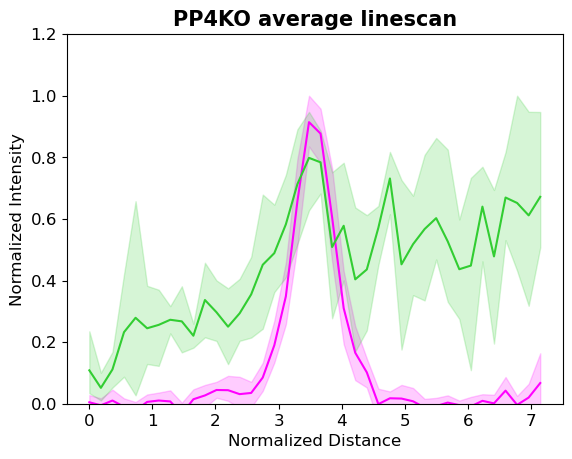

In [9]:
# plotting PP4KO values

sns.lineplot(x = 'distance', y = 'normalized RFP', 
             data = norm_data[norm_data['genotype']=='PP4KO'], color = 'magenta')

sns.lineplot(x = 'distance', y = 'normalized GFP', 
             data = norm_data[(norm_data['genotype']=='PP4KO') & (norm_data['normalized GFP']>0)], color = 'limegreen')

plt.title('PP4KO average linescan', fontsize = 15, fontweight = 'bold')
plt.xlabel('Normalized Distance', fontsize = 12)
plt.ylabel('Normalized Intensity', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0,1.2)

#plt.savefig('PP4KO average.svg', dpi = 600, bbox_inches = 'tight')
plt.show();

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2675., 2700., 2725., 2750., 2775., 2800., 2825., 2850., 2875.,
        2900.]),
 [Text(0, 2675.0, '2675'),
  Text(0, 2700.0, '2700'),
  Text(0, 2725.0, '2725'),
  Text(0, 2750.0, '2750'),
  Text(0, 2775.0, '2775'),
  Text(0, 2800.0, '2800'),
  Text(0, 2825.0, '2825'),
  Text(0, 2850.0, '2850'),
  Text(0, 2875.0, '2875'),
  Text(0, 2900.0, '2900')])

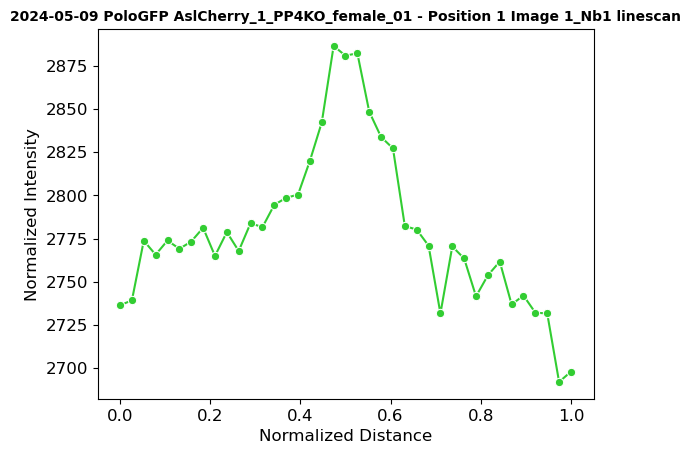

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1750., 1800., 1850., 1900., 1950., 2000., 2050., 2100.]),
 [Text(0, 1750.0, '1750'),
  Text(0, 1800.0, '1800'),
  Text(0, 1850.0, '1850'),
  Text(0, 1900.0, '1900'),
  Text(0, 1950.0, '1950'),
  Text(0, 2000.0, '2000'),
  Text(0, 2050.0, '2050'),
  Text(0, 2100.0, '2100')])

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb3 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2150., 2200., 2250., 2300., 2350., 2400., 2450.]),
 [Text(0, 2150.0, '2150'),
  Text(0, 2200.0, '2200'),
  Text(0, 2250.0, '2250'),
  Text(0, 2300.0, '2300'),
  Text(0, 2350.0, '2350'),
  Text(0, 2400.0, '2400'),
  Text(0, 2450.0, '2450')])

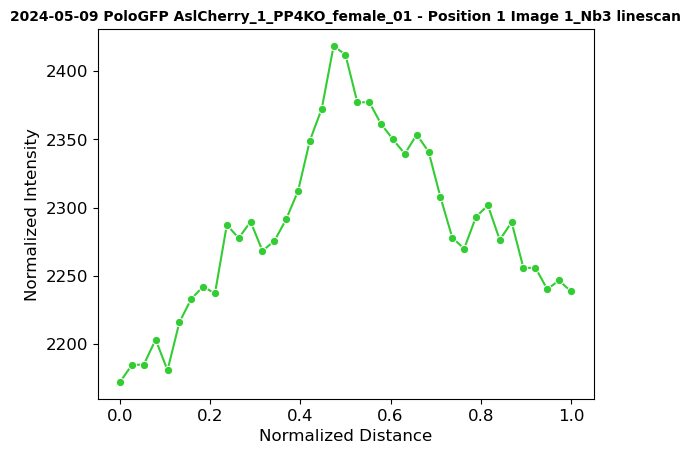

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb4 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2200., 2250., 2300., 2350., 2400., 2450., 2500., 2550.]),
 [Text(0, 2200.0, '2200'),
  Text(0, 2250.0, '2250'),
  Text(0, 2300.0, '2300'),
  Text(0, 2350.0, '2350'),
  Text(0, 2400.0, '2400'),
  Text(0, 2450.0, '2450'),
  Text(0, 2500.0, '2500'),
  Text(0, 2550.0, '2550')])

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb5 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2450., 2500., 2550., 2600., 2650., 2700., 2750.]),
 [Text(0, 2450.0, '2450'),
  Text(0, 2500.0, '2500'),
  Text(0, 2550.0, '2550'),
  Text(0, 2600.0, '2600'),
  Text(0, 2650.0, '2650'),
  Text(0, 2700.0, '2700'),
  Text(0, 2750.0, '2750')])

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb1.ims linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2025., 2050., 2075., 2100., 2125., 2150., 2175., 2200., 2225.,
        2250.]),
 [Text(0, 2025.0, '2025'),
  Text(0, 2050.0, '2050'),
  Text(0, 2075.0, '2075'),
  Text(0, 2100.0, '2100'),
  Text(0, 2125.0, '2125'),
  Text(0, 2150.0, '2150'),
  Text(0, 2175.0, '2175'),
  Text(0, 2200.0, '2200'),
  Text(0, 2225.0, '2225'),
  Text(0, 2250.0, '2250')])

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb2_A linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([4480., 4500., 4520., 4540., 4560., 4580., 4600., 4620., 4640.]),
 [Text(0, 4480.0, '4480'),
  Text(0, 4500.0, '4500'),
  Text(0, 4520.0, '4520'),
  Text(0, 4540.0, '4540'),
  Text(0, 4560.0, '4560'),
  Text(0, 4580.0, '4580'),
  Text(0, 4600.0, '4600'),
  Text(0, 4620.0, '4620'),
  Text(0, 4640.0, '4640')])

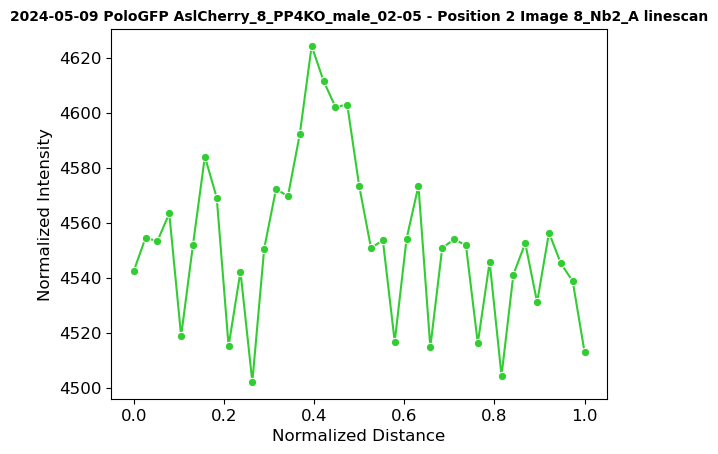

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb4 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2130., 2140., 2150., 2160., 2170., 2180., 2190., 2200., 2210.,
        2220., 2230.]),
 [Text(0, 2130.0, '2130'),
  Text(0, 2140.0, '2140'),
  Text(0, 2150.0, '2150'),
  Text(0, 2160.0, '2160'),
  Text(0, 2170.0, '2170'),
  Text(0, 2180.0, '2180'),
  Text(0, 2190.0, '2190'),
  Text(0, 2200.0, '2200'),
  Text(0, 2210.0, '2210'),
  Text(0, 2220.0, '2220'),
  Text(0, 2230.0, '2230')])

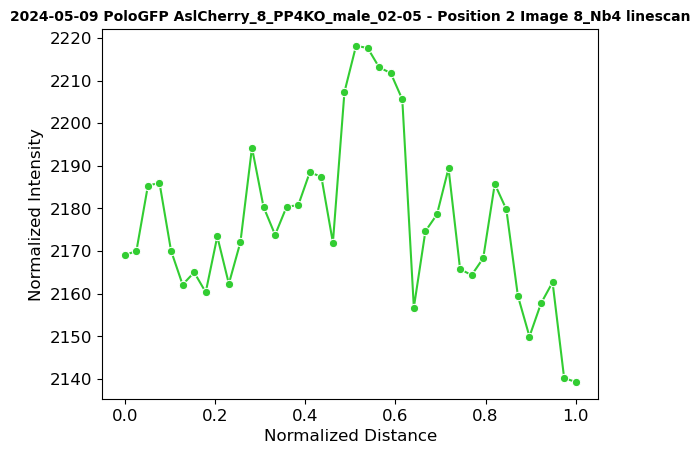

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb5 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([4300., 4320., 4340., 4360., 4380., 4400., 4420., 4440., 4460.]),
 [Text(0, 4300.0, '4300'),
  Text(0, 4320.0, '4320'),
  Text(0, 4340.0, '4340'),
  Text(0, 4360.0, '4360'),
  Text(0, 4380.0, '4380'),
  Text(0, 4400.0, '4400'),
  Text(0, 4420.0, '4420'),
  Text(0, 4440.0, '4440'),
  Text(0, 4460.0, '4460')])

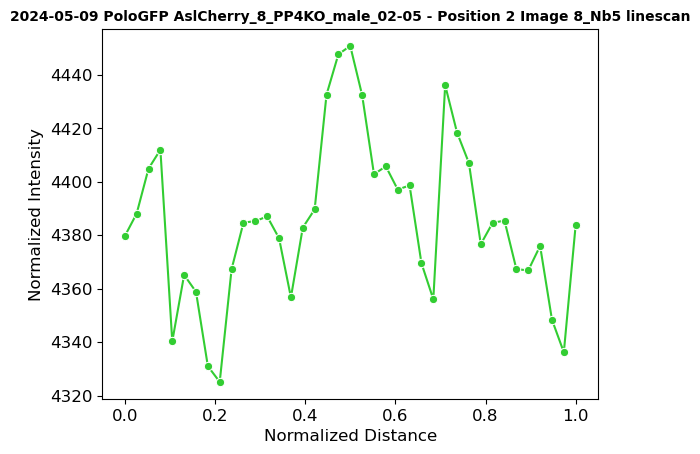

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1800., 1820., 1840., 1860., 1880., 1900., 1920., 1940., 1960.,
        1980.]),
 [Text(0, 1800.0, '1800'),
  Text(0, 1820.0, '1820'),
  Text(0, 1840.0, '1840'),
  Text(0, 1860.0, '1860'),
  Text(0, 1880.0, '1880'),
  Text(0, 1900.0, '1900'),
  Text(0, 1920.0, '1920'),
  Text(0, 1940.0, '1940'),
  Text(0, 1960.0, '1960'),
  Text(0, 1980.0, '1980')])

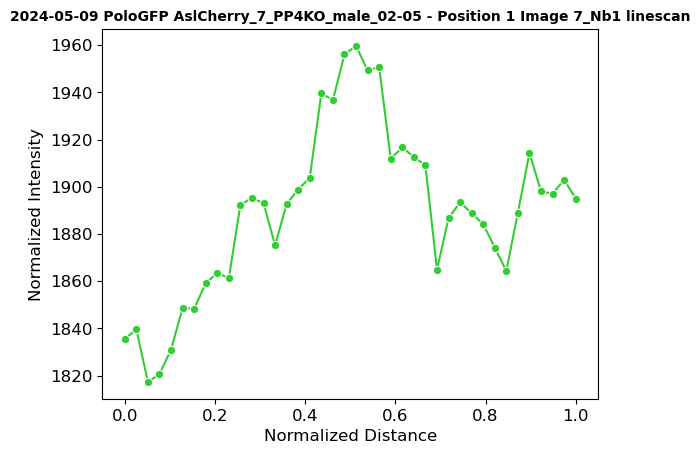

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2700., 2750., 2800., 2850., 2900., 2950., 3000., 3050., 3100.]),
 [Text(0, 2700.0, '2700'),
  Text(0, 2750.0, '2750'),
  Text(0, 2800.0, '2800'),
  Text(0, 2850.0, '2850'),
  Text(0, 2900.0, '2900'),
  Text(0, 2950.0, '2950'),
  Text(0, 3000.0, '3000'),
  Text(0, 3050.0, '3050'),
  Text(0, 3100.0, '3100')])

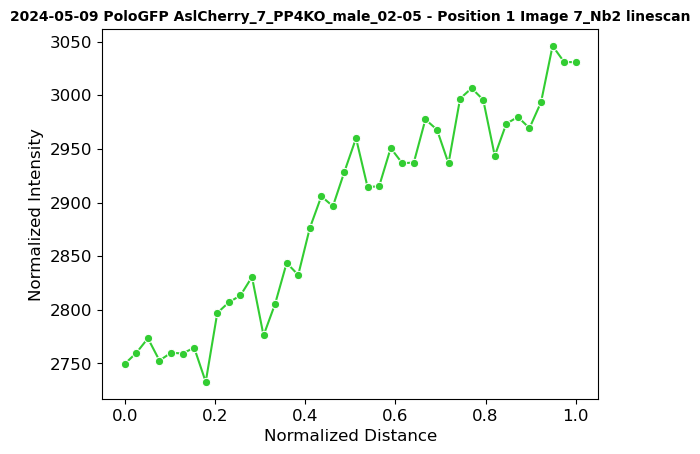

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb3 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2340., 2360., 2380., 2400., 2420., 2440., 2460., 2480.]),
 [Text(0, 2340.0, '2340'),
  Text(0, 2360.0, '2360'),
  Text(0, 2380.0, '2380'),
  Text(0, 2400.0, '2400'),
  Text(0, 2420.0, '2420'),
  Text(0, 2440.0, '2440'),
  Text(0, 2460.0, '2460'),
  Text(0, 2480.0, '2480')])

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1920., 1940., 1960., 1980., 2000., 2020., 2040., 2060., 2080.]),
 [Text(0, 1920.0, '1920'),
  Text(0, 1940.0, '1940'),
  Text(0, 1960.0, '1960'),
  Text(0, 1980.0, '1980'),
  Text(0, 2000.0, '2000'),
  Text(0, 2020.0, '2020'),
  Text(0, 2040.0, '2040'),
  Text(0, 2060.0, '2060'),
  Text(0, 2080.0, '2080')])

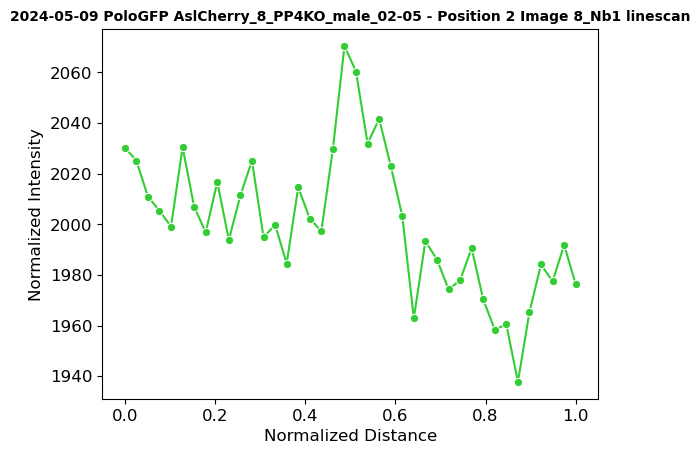

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2160., 2180., 2200., 2220., 2240., 2260., 2280.]),
 [Text(0, 2160.0, '2160'),
  Text(0, 2180.0, '2180'),
  Text(0, 2200.0, '2200'),
  Text(0, 2220.0, '2220'),
  Text(0, 2240.0, '2240'),
  Text(0, 2260.0, '2260'),
  Text(0, 2280.0, '2280')])

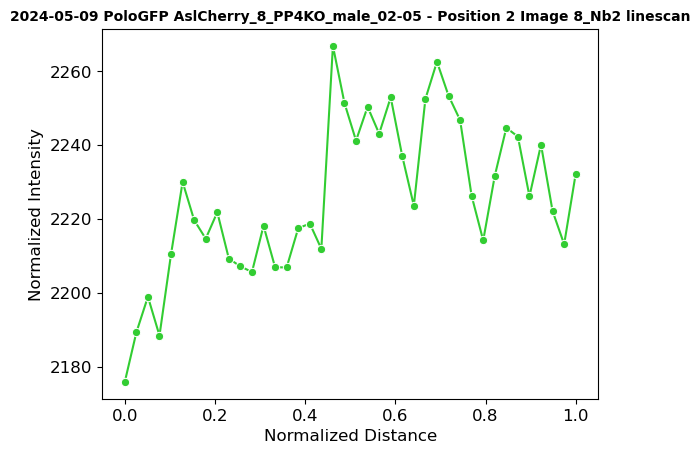

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1800., 1850., 1900., 1950., 2000., 2050., 2100., 2150.]),
 [Text(0, 1800.0, '1800'),
  Text(0, 1850.0, '1850'),
  Text(0, 1900.0, '1900'),
  Text(0, 1950.0, '1950'),
  Text(0, 2000.0, '2000'),
  Text(0, 2050.0, '2050'),
  Text(0, 2100.0, '2100'),
  Text(0, 2150.0, '2150')])

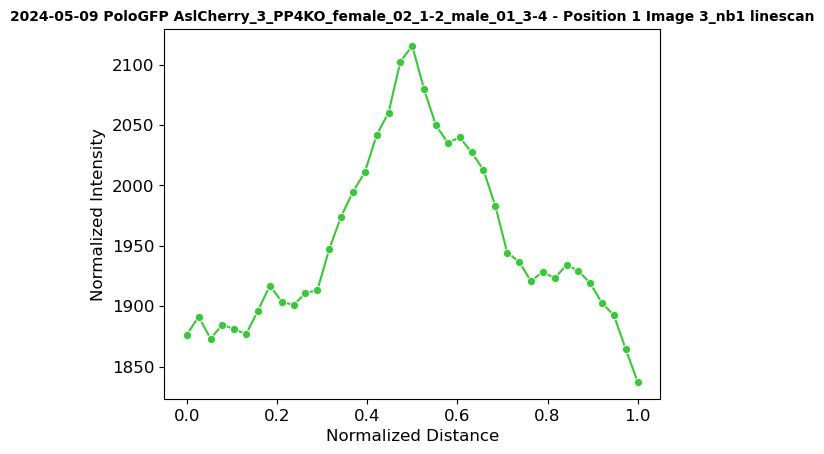

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1920., 1940., 1960., 1980., 2000., 2020., 2040., 2060., 2080.,
        2100.]),
 [Text(0, 1920.0, '1920'),
  Text(0, 1940.0, '1940'),
  Text(0, 1960.0, '1960'),
  Text(0, 1980.0, '1980'),
  Text(0, 2000.0, '2000'),
  Text(0, 2020.0, '2020'),
  Text(0, 2040.0, '2040'),
  Text(0, 2060.0, '2060'),
  Text(0, 2080.0, '2080'),
  Text(0, 2100.0, '2100')])

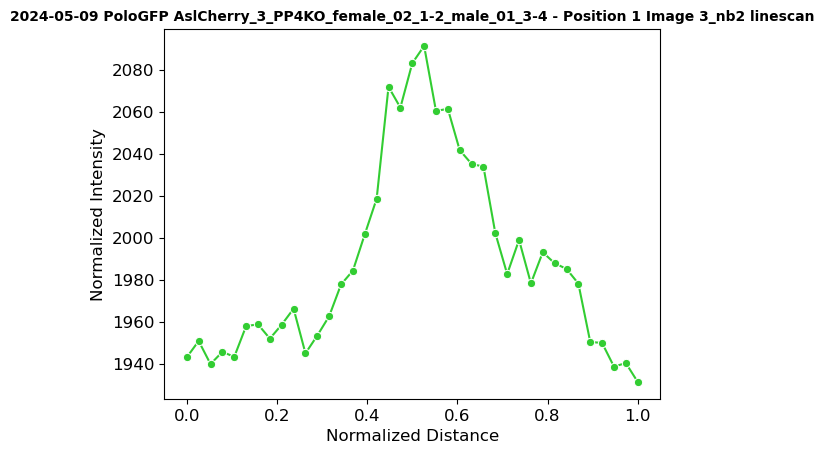

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb3 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1700., 1750., 1800., 1850., 1900., 1950., 2000.]),
 [Text(0, 1700.0, '1700'),
  Text(0, 1750.0, '1750'),
  Text(0, 1800.0, '1800'),
  Text(0, 1850.0, '1850'),
  Text(0, 1900.0, '1900'),
  Text(0, 1950.0, '1950'),
  Text(0, 2000.0, '2000')])

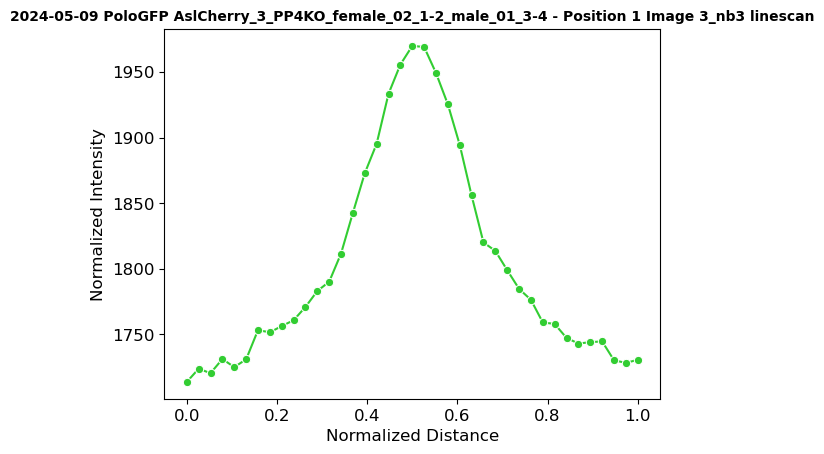

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb4 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1500., 1550., 1600., 1650., 1700., 1750., 1800., 1850.]),
 [Text(0, 1500.0, '1500'),
  Text(0, 1550.0, '1550'),
  Text(0, 1600.0, '1600'),
  Text(0, 1650.0, '1650'),
  Text(0, 1700.0, '1700'),
  Text(0, 1750.0, '1750'),
  Text(0, 1800.0, '1800'),
  Text(0, 1850.0, '1850')])

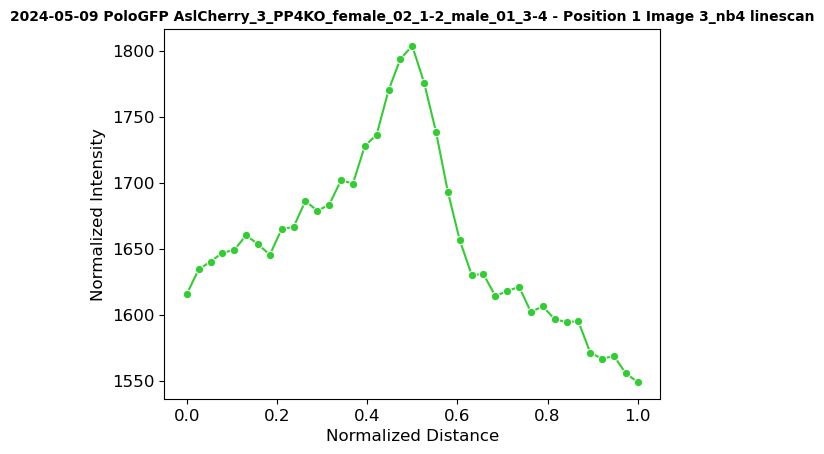

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb5 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([2100., 2150., 2200., 2250., 2300., 2350., 2400., 2450., 2500.]),
 [Text(0, 2100.0, '2100'),
  Text(0, 2150.0, '2150'),
  Text(0, 2200.0, '2200'),
  Text(0, 2250.0, '2250'),
  Text(0, 2300.0, '2300'),
  Text(0, 2350.0, '2350'),
  Text(0, 2400.0, '2400'),
  Text(0, 2450.0, '2450'),
  Text(0, 2500.0, '2500')])

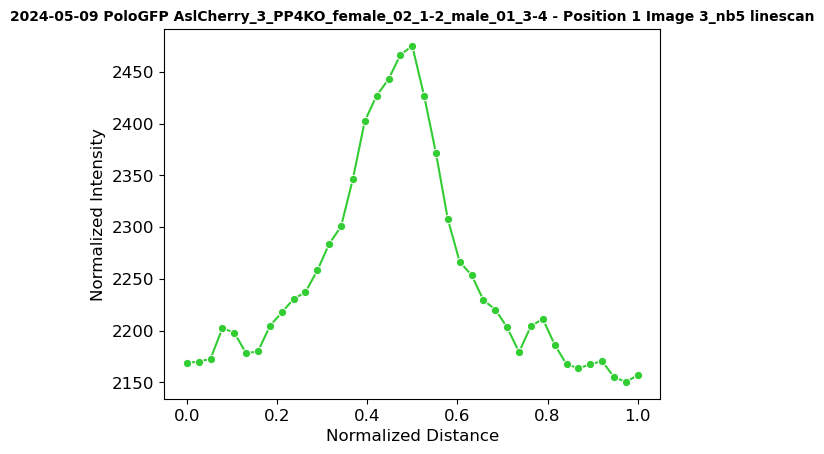

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb6 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1625., 1650., 1675., 1700., 1725., 1750., 1775., 1800., 1825.,
        1850.]),
 [Text(0, 1625.0, '1625'),
  Text(0, 1650.0, '1650'),
  Text(0, 1675.0, '1675'),
  Text(0, 1700.0, '1700'),
  Text(0, 1725.0, '1725'),
  Text(0, 1750.0, '1750'),
  Text(0, 1775.0, '1775'),
  Text(0, 1800.0, '1800'),
  Text(0, 1825.0, '1825'),
  Text(0, 1850.0, '1850')])

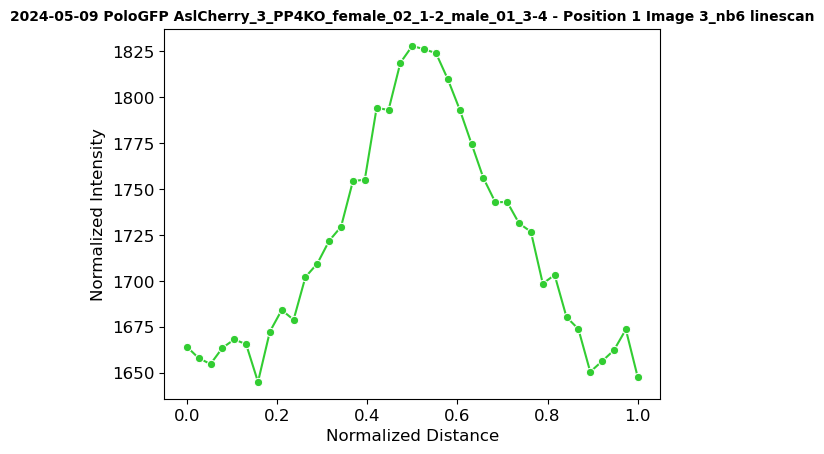

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb7 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1600., 1650., 1700., 1750., 1800., 1850., 1900.]),
 [Text(0, 1600.0, '1600'),
  Text(0, 1650.0, '1650'),
  Text(0, 1700.0, '1700'),
  Text(0, 1750.0, '1750'),
  Text(0, 1800.0, '1800'),
  Text(0, 1850.0, '1850'),
  Text(0, 1900.0, '1900')])

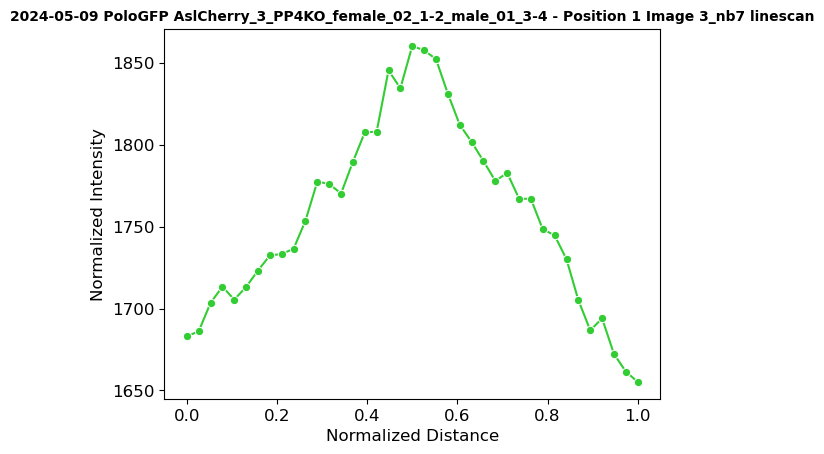

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1500., 1550., 1600., 1650., 1700., 1750., 1800., 1850., 1900.]),
 [Text(0, 1500.0, '1500'),
  Text(0, 1550.0, '1550'),
  Text(0, 1600.0, '1600'),
  Text(0, 1650.0, '1650'),
  Text(0, 1700.0, '1700'),
  Text(0, 1750.0, '1750'),
  Text(0, 1800.0, '1800'),
  Text(0, 1850.0, '1850'),
  Text(0, 1900.0, '1900')])

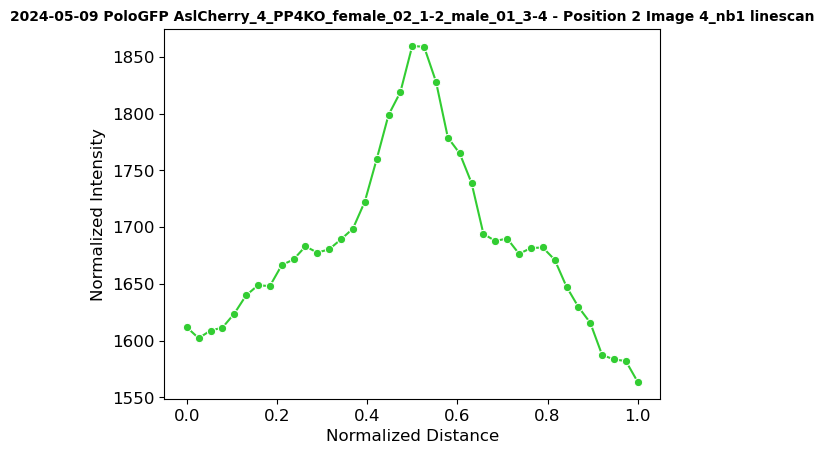

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1650., 1700., 1750., 1800., 1850., 1900., 1950., 2000.]),
 [Text(0, 1650.0, '1650'),
  Text(0, 1700.0, '1700'),
  Text(0, 1750.0, '1750'),
  Text(0, 1800.0, '1800'),
  Text(0, 1850.0, '1850'),
  Text(0, 1900.0, '1900'),
  Text(0, 1950.0, '1950'),
  Text(0, 2000.0, '2000')])

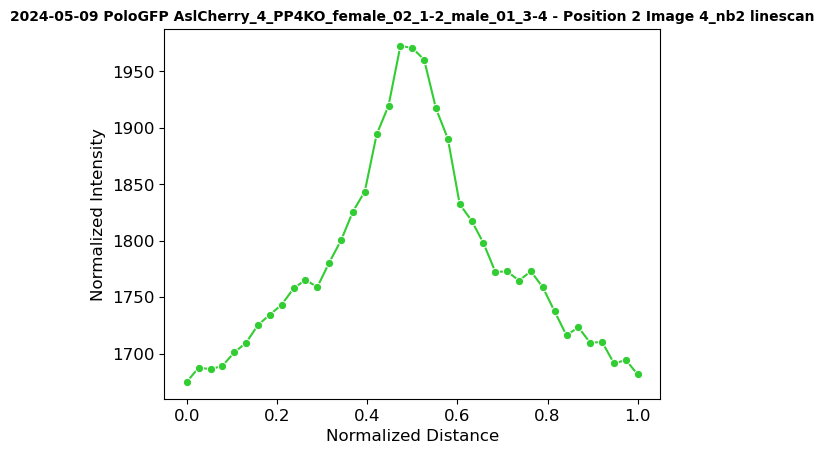

<Axes: xlabel='normalized distance', ylabel='GFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb3 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([1750., 1800., 1850., 1900., 1950., 2000., 2050., 2100.]),
 [Text(0, 1750.0, '1750'),
  Text(0, 1800.0, '1800'),
  Text(0, 1850.0, '1850'),
  Text(0, 1900.0, '1900'),
  Text(0, 1950.0, '1950'),
  Text(0, 2000.0, '2000'),
  Text(0, 2050.0, '2050'),
  Text(0, 2100.0, '2100')])

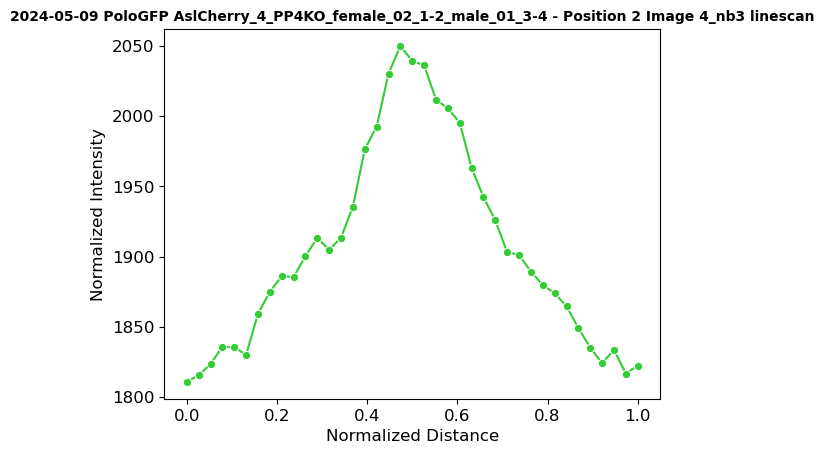

In [10]:
#plotting each cell individually 

stats_frame = pd.DataFrame(columns=['file', 'genotype', 'GFP vs RFP pval']) # makes empty dataframe

for i in range(0, len(files)): # initializes loop based on how many files there are in the dataframe
    #pf = norm_data[(norm_data['file'] == files[i]) & (norm_data['normalized distance'] > 0.4) & (norm_data['normalized distance'] < 0.6)] # gets data to plot
    pf = norm_data[(norm_data['file'] == files[i])]
    # plots data with annotations/axis labels
    sns.lineplot(x = 'normalized distance', y = 'GFP', 
             data = pf, color = 'limegreen', marker = 'o');
    
    plt.title(f'{files[i]} linescan', fontsize = 10, fontweight = 'bold');
    plt.xlabel('Normalized Distance', fontsize = 12);
    plt.ylabel('Normalized Intensity', fontsize = 12);
    plt.xticks(fontsize = 12);
    plt.yticks(fontsize = 12);
    #plt.ylim(1000,4000)

    # runs t-test between RFP and GFP distributions
    param1 = pf['RFP']
    param2 = pf['GFP']
    w = independent_ttest(param1, param2, 0.05)[3] # stores p value as a variable

    stats_frame.loc[i, 'file'] = files[i]
    stats_frame.loc[i, 'genotype'] = pf.reset_index().loc[0, 'genotype']
    stats_frame.loc[i, 'GFP vs RFP pval'] = w

    #plt.axhline(y = 0.5)
    os.chdir(figs_dir + '/whh/uncorrected/')
    plt.savefig('uncorrected GFP' + files[i] + '.svg', dpi = 600, bbox_inches = 'tight')
    plt.show();
    

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

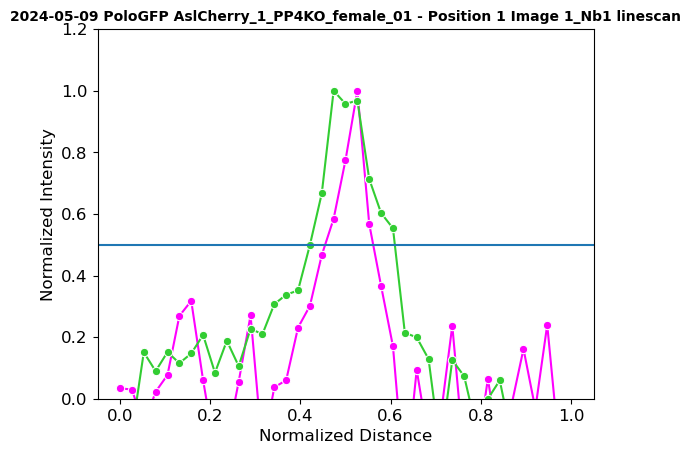

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb3 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

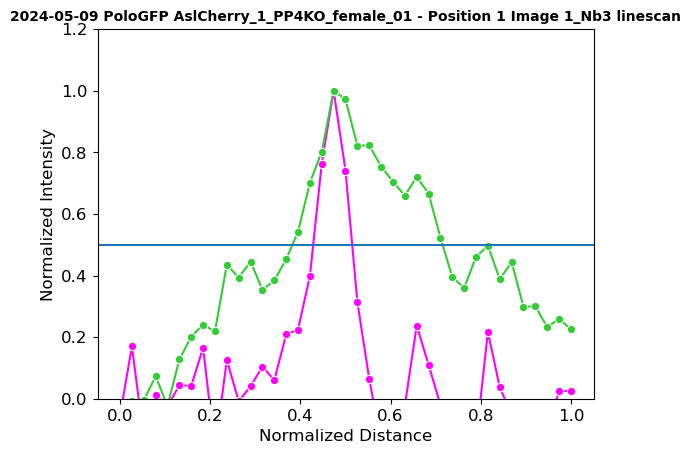

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb4 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

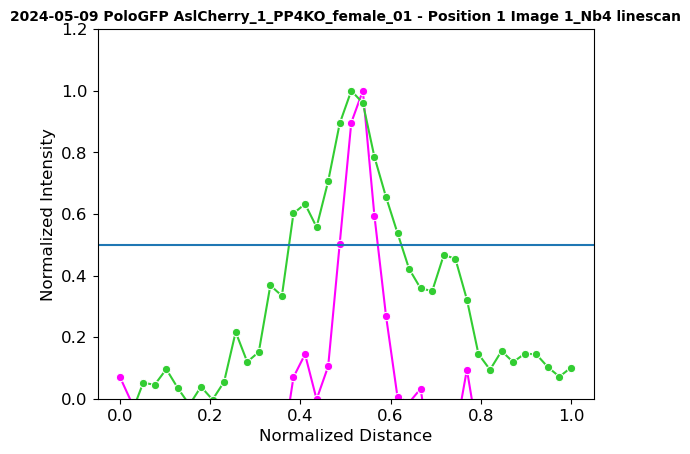

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb5 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

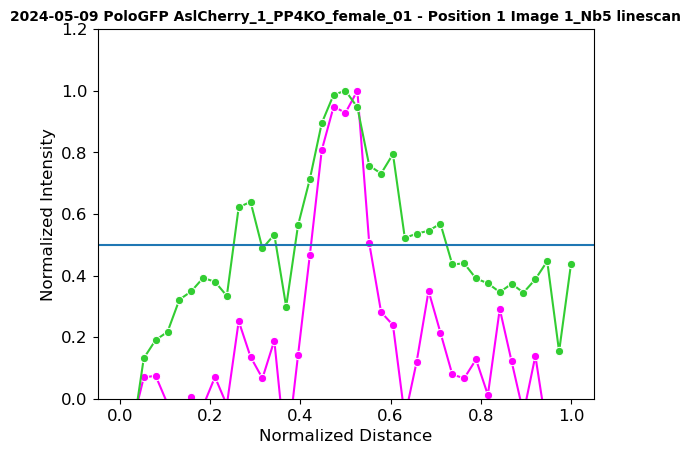

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb1.ims linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

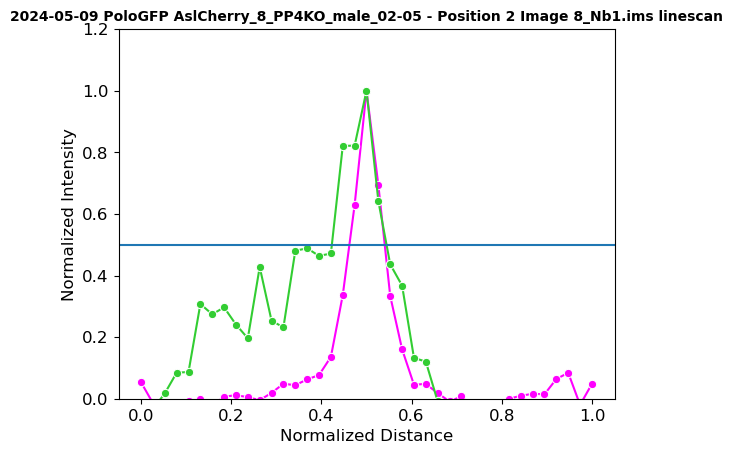

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb2_A linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
         1.25]),
 [Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

(0.0, 1.2)

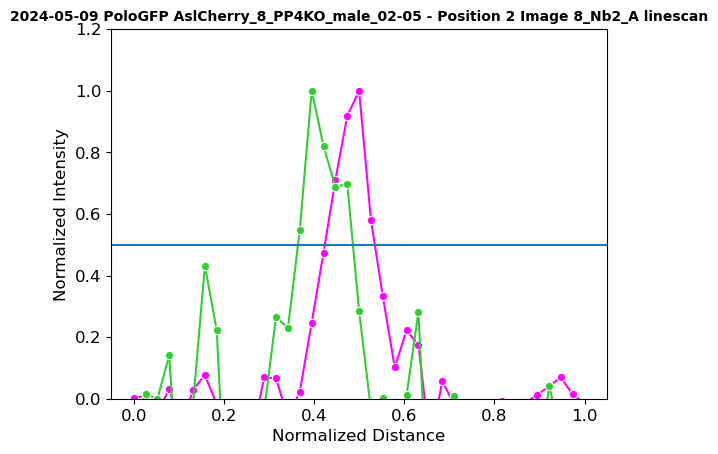

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb4 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, -1.25, '−1.25'),
  Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

(0.0, 1.2)

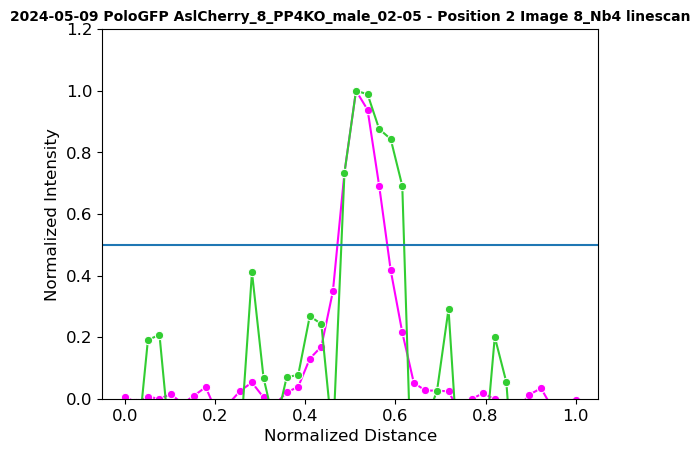

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb5 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

(0.0, 1.2)

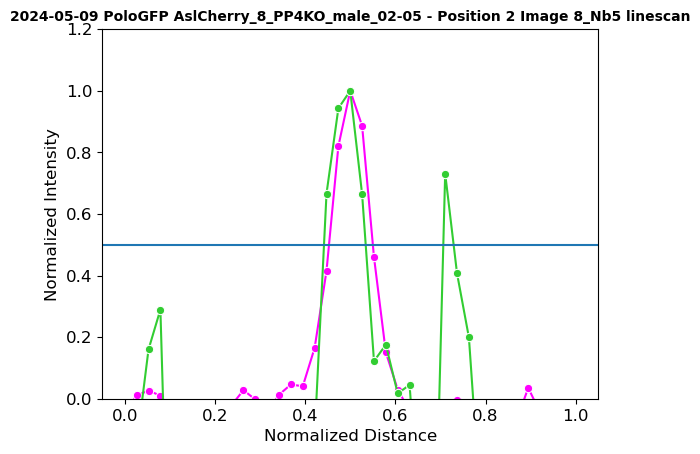

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

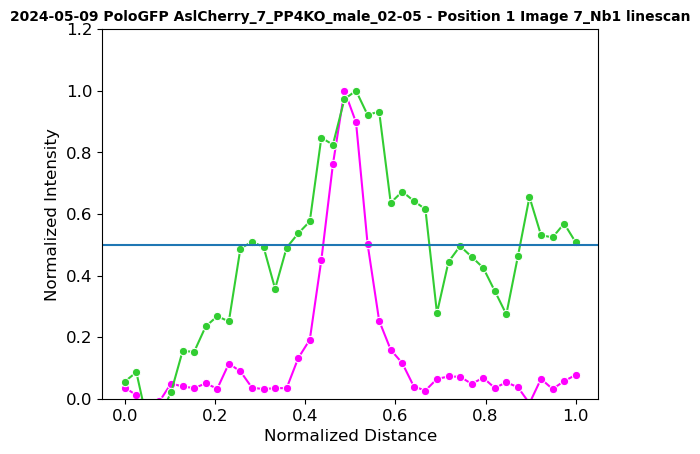

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

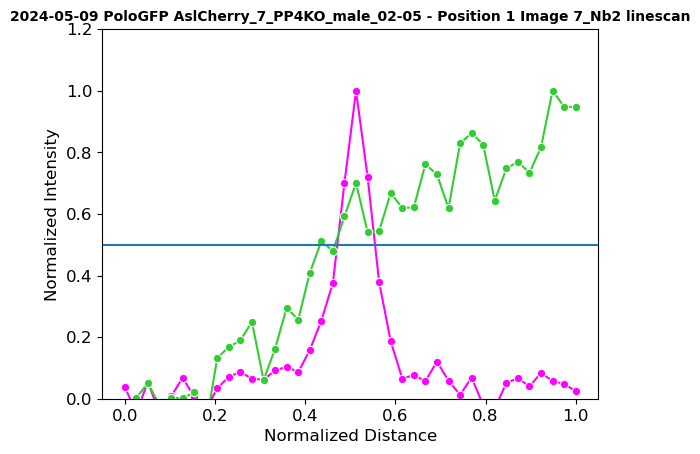

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb3 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-4., -3., -2., -1.,  0.,  1.,  2.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2')])

(0.0, 1.2)

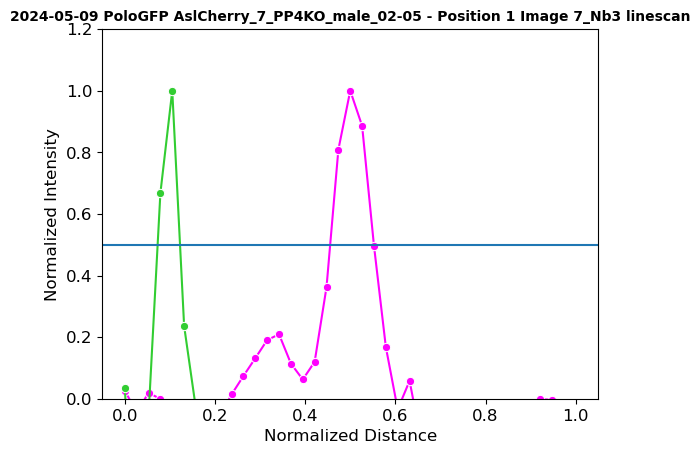

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

(0.0, 1.2)

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

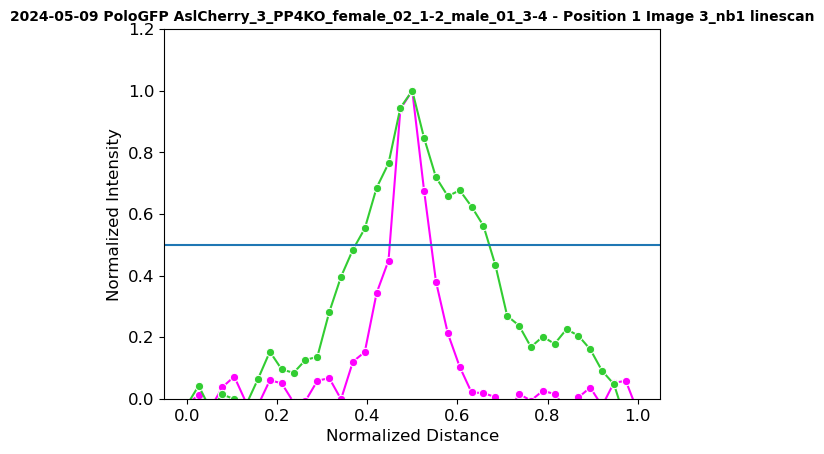

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb3 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

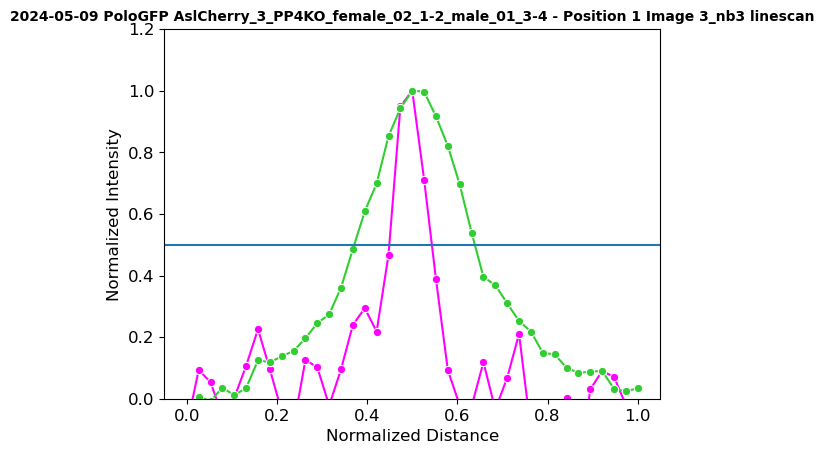

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb4 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb5 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb6 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

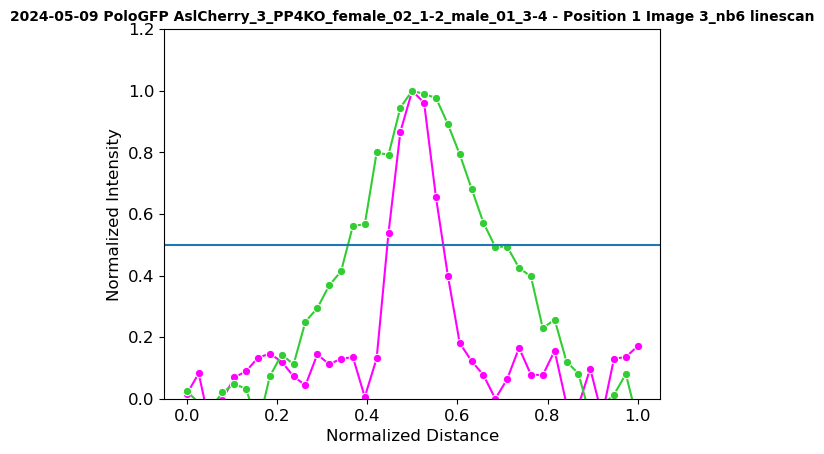

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb7 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

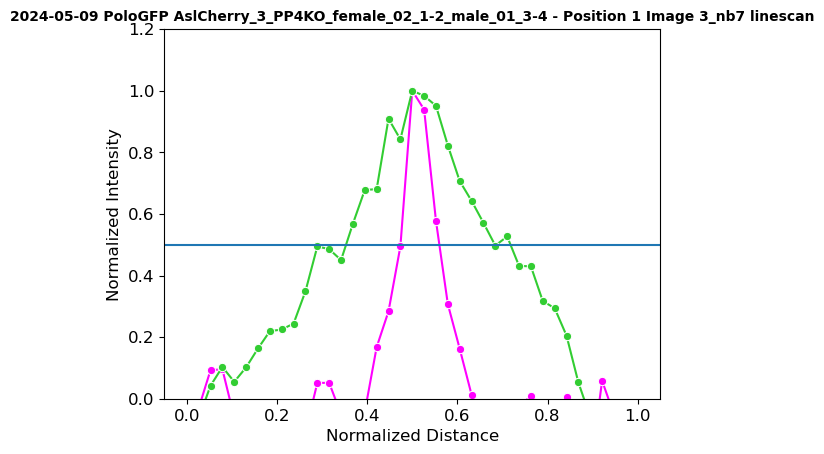

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb1 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

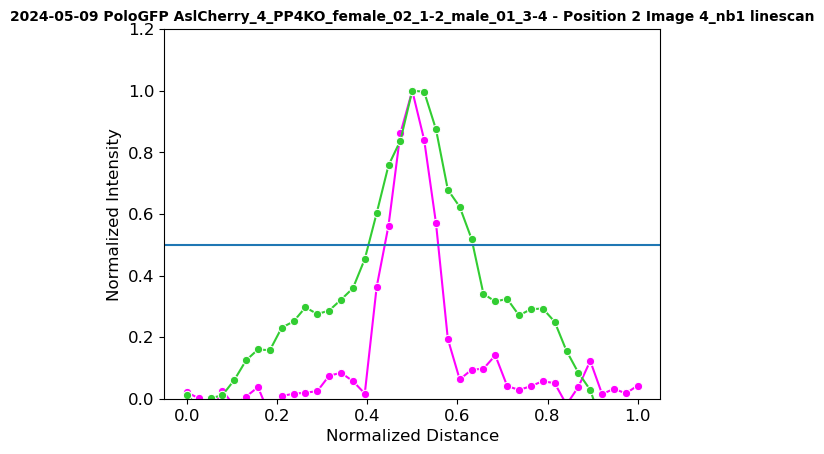

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb2 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

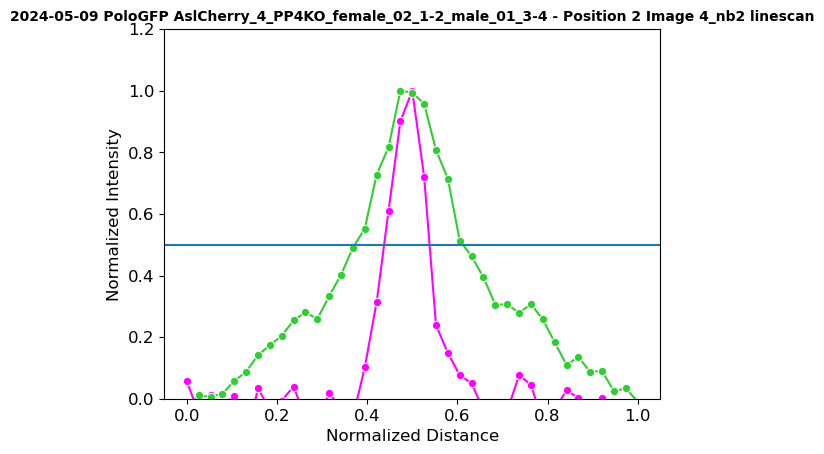

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

<Axes: xlabel='normalized distance', ylabel='normalized RFP'>

Text(0.5, 1.0, '2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb3 linescan')

Text(0.5, 0, 'Normalized Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

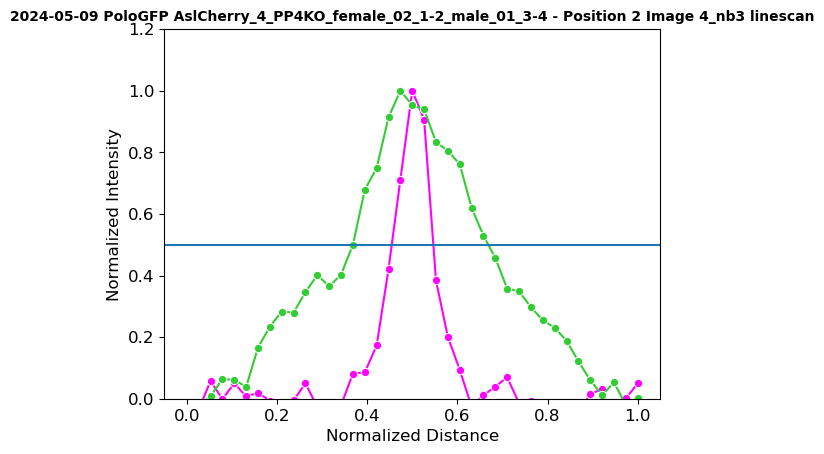

In [11]:
#plotting each cell individually 

stats_frame = pd.DataFrame(columns=['file', 'genotype', 'GFP vs RFP pval']) # makes empty dataframe

for i in range(0, len(files)): # initializes loop based on how many files there are in the dataframe
    #pf = norm_data[(norm_data['file'] == files[i]) & (norm_data['normalized distance'] > 0.4) & (norm_data['normalized distance'] < 0.6)] # gets data to plot
    pf = norm_data[(norm_data['file'] == files[i])]
    # plots data with annotations/axis labels
    sns.lineplot(x = 'normalized distance', y = 'normalized RFP', 
             data = pf, color = 'magenta', marker = 'o');

    sns.lineplot(x = 'normalized distance', y = 'normalized GFP', 
                 data = pf, color = 'limegreen', marker = 'o');
    
    plt.title(f'{files[i]} linescan', fontsize = 10, fontweight = 'bold');
    plt.xlabel('Normalized Distance', fontsize = 12);
    plt.ylabel('Normalized Intensity', fontsize = 12);
    plt.xticks(fontsize = 12);
    plt.yticks(fontsize = 12);
    plt.ylim(0,1.2)

    # runs t-test between RFP and GFP distributions
    param1 = pf['normalized RFP']
    param2 = pf['normalized GFP']
    w = independent_ttest(param1, param2, 0.05)[3] # stores p value as a variable

    stats_frame.loc[i, 'file'] = files[i]
    stats_frame.loc[i, 'genotype'] = pf.reset_index().loc[0, 'genotype']
    stats_frame.loc[i, 'GFP vs RFP pval'] = w

    plt.axhline(y = 0.5)
    #plt.savefig(files[i] + '.svg', dpi = 600, bbox_inches = 'tight')
    plt.show();
    

In [12]:
sns.lineplot(x = 'distance', y = 'normalized RFP', color = 'red', data = norm_data[norm_data['genotype']=='WT'],
            err_style='band', errorbar = 'sd')
sns.lineplot(x = 'distance', y = 'normalized GFP', color = 'limegreen', data = norm_data[norm_data['genotype']=='WT'],
            err_style = 'band', errorbar = 'sd');

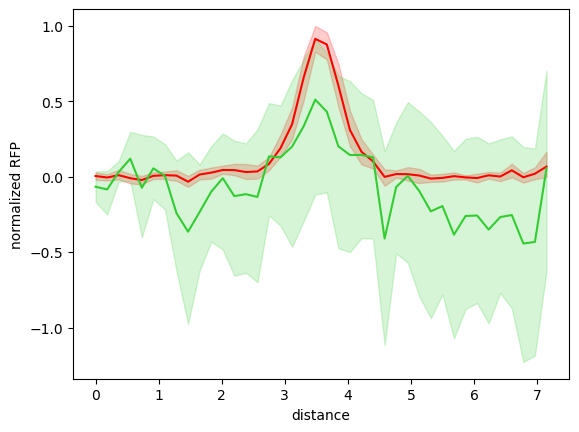

In [13]:
sns.lineplot(x = 'distance', y = 'normalized RFP', color = 'red', data = norm_data[norm_data['genotype']=='PP4KO'],
            err_style='band')
sns.lineplot(x = 'distance', y = 'normalized GFP', color = 'limegreen', data = norm_data[norm_data['genotype']=='PP4KO'],
            err_style = 'band');

In [14]:
norm_data

index                                               file genotype  \
0       0  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
1       1  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
2       2  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
3       3  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
4       4  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
5       5  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
6       6  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
7       7  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
8       8  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
9       9  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
10     10  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
11     11  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
12     12  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
13     13  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
14     14  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
15     15  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
16     16  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
17     17  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
18     18  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
19     19  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
20     20  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
21     21  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
22     22  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
23     23  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
24     24  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
25     25  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
26     26  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
27     27  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
28     28  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
29     29  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
30     30  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
31     31  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
32     32  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
33     33  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
34     34  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
35     35  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
36     36  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
37     37  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
38     38  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
0      39  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
1      40  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
2      41  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
3      42  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
4      43  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
5      44  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
6      45  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
7      46  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
8      47  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
9      48  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
10     49  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
11     50  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
12     51  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
13     52  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT   
14     53  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...  

# Interpolating width at half height measurement points
_(Generated with assistance from ChatGPT)_

'2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb1'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'WT Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.7422786510802029
GFP Width at Half-Height: 1.3111641985063853


'2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb2'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'WT Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.5363385316544242
GFP Width at Half-Height: 1.5359800673470545


'2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb3'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'WT Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.6024907940038369
GFP Width at Half-Height: 2.31928612882907


'2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb4'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'WT Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.6050942929286975
GFP Width at Half-Height: 1.7792627576730178


'2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01 - Position 1 Image 1_Nb5'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'WT Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

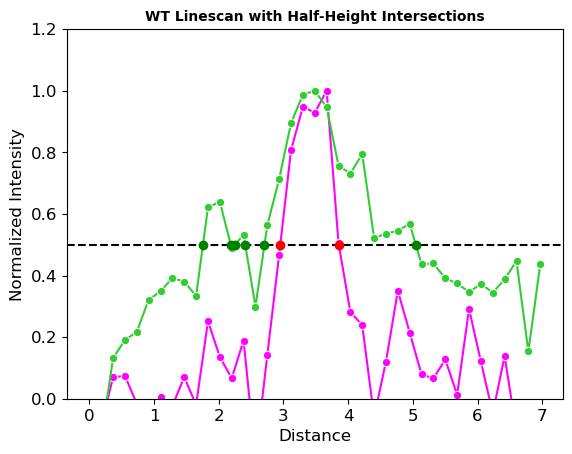

RFP Width at Half-Height: 0.9036800465045327
GFP Width at Half-Height: 3.2887107600200256


'2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb1.ims'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

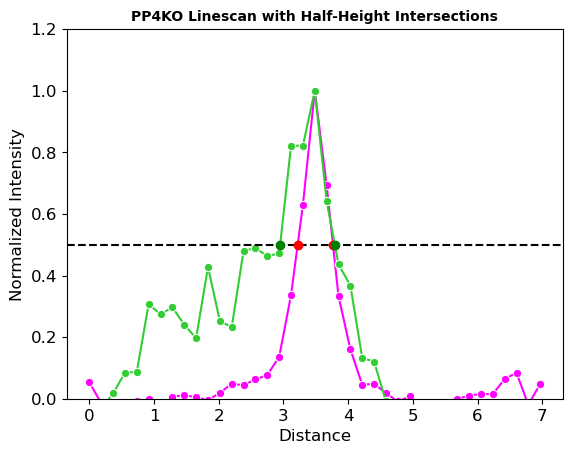

RFP Width at Half-Height: 0.5460253539540543
GFP Width at Half-Height: 0.8447146453222469


'2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb2_A'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
         1.25]),
 [Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

(0.0, 1.2)

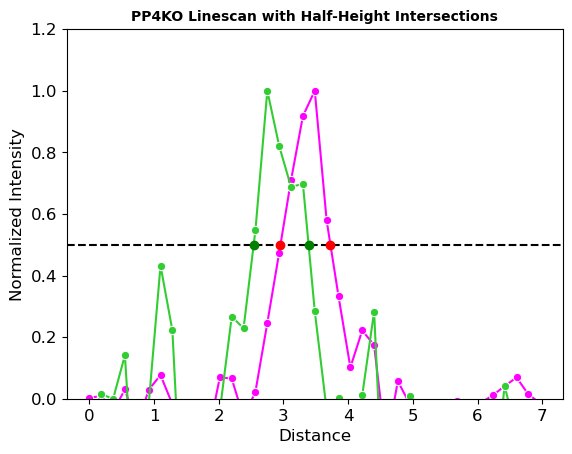

RFP Width at Half-Height: 0.7719347412101847
GFP Width at Half-Height: 0.848298503727217


'2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb4'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, -1.25, '−1.25'),
  Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

(0.0, 1.2)

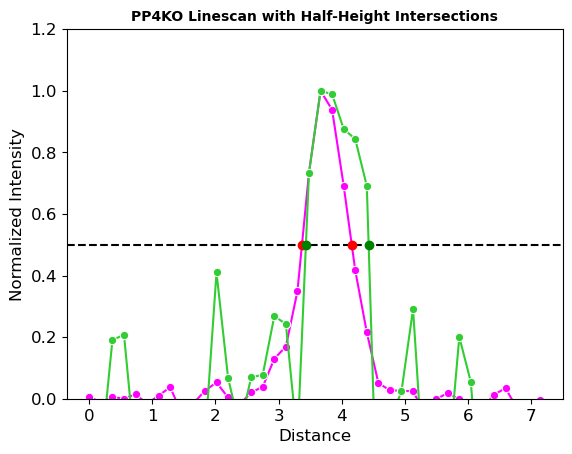

RFP Width at Half-Height: 0.7892558528393434
GFP Width at Half-Height: 0.9948099576091733


'2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb5'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

(0.0, 1.2)

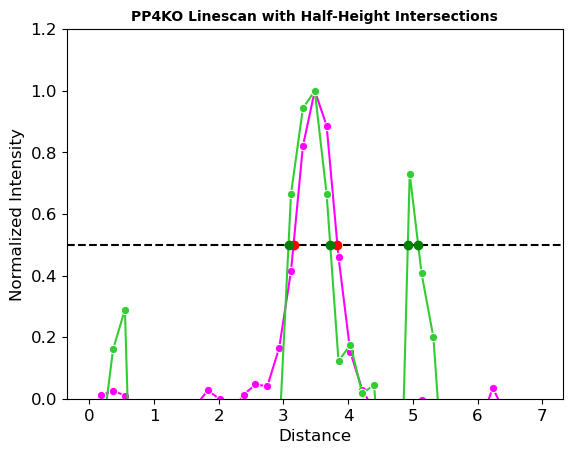

RFP Width at Half-Height: 0.67765696526551
GFP Width at Half-Height: 2.002713370472173


'2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb1'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

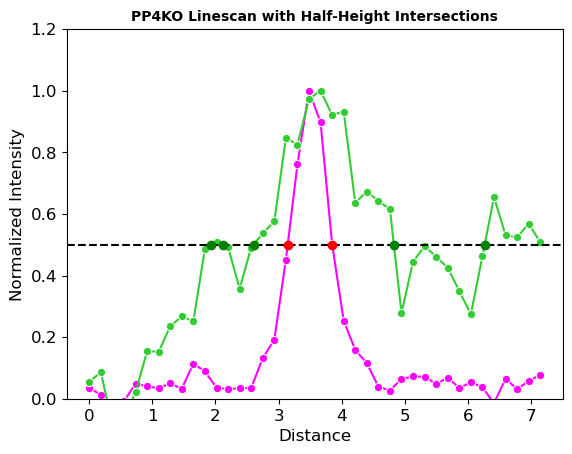

RFP Width at Half-Height: 0.7058899650569543
GFP Width at Half-Height: 4.3324603387402485


'2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb2'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

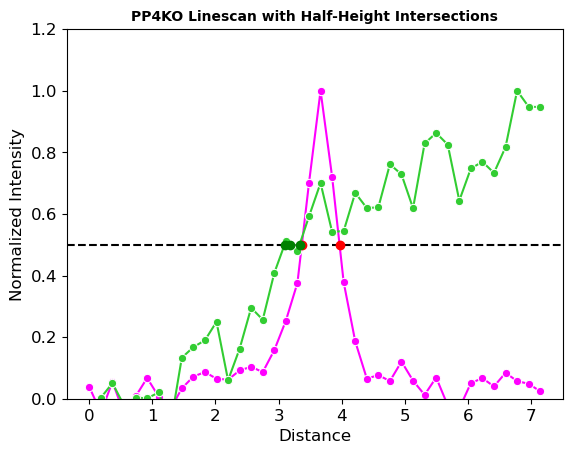

RFP Width at Half-Height: 0.5979526344015351
GFP Width at Half-Height: 0.2375950377255469


'2024-05-09 PoloGFP AslCherry_7_PP4KO_male_02-05 - Position 1 Image 7_Nb3'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-4., -3., -2., -1.,  0.,  1.,  2.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2')])

(0.0, 1.2)

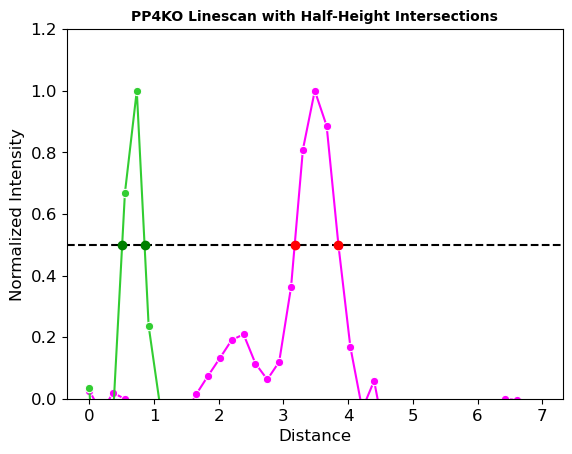

RFP Width at Half-Height: 0.6751800666682262
GFP Width at Half-Height: 0.3459484258799941


'2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb1'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

(0.0, 1.2)

RFP Width at Half-Height: 0.673413157869776
GFP Width at Half-Height: 0.4057816508250083


'2024-05-09 PoloGFP AslCherry_8_PP4KO_male_02-05 - Position 2 Image 8_Nb2'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'PP4KO Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

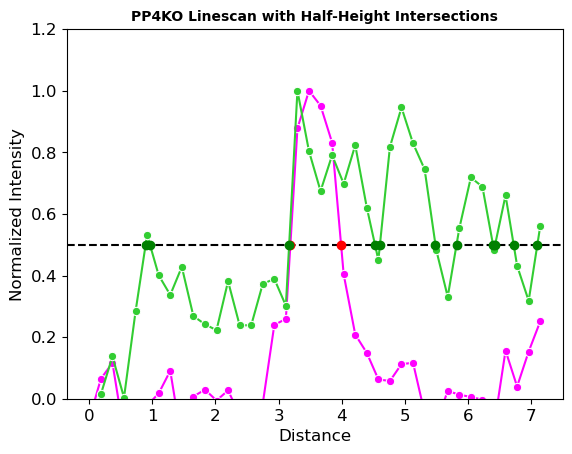

RFP Width at Half-Height: 0.8039453578619904
GFP Width at Half-Height: 6.211413436977091


'2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb1'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

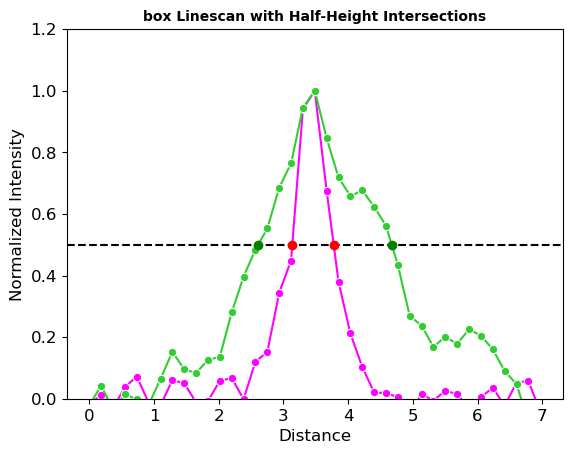

RFP Width at Half-Height: 0.6397710394514404
GFP Width at Half-Height: 2.0632301253807546


'2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb2'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

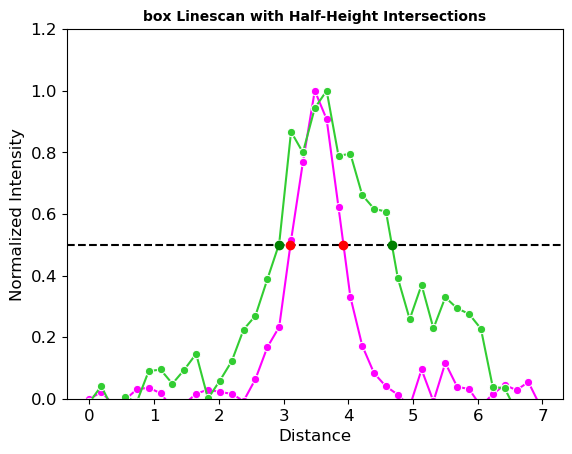

RFP Width at Half-Height: 0.8188882393981034
GFP Width at Half-Height: 1.7462352524486455


'2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb3'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

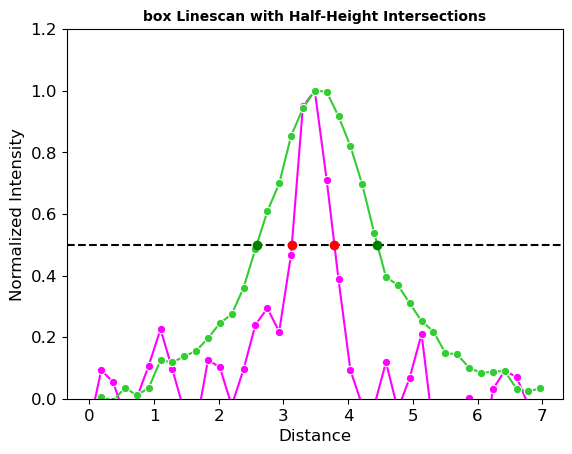

RFP Width at Half-Height: 0.6574224859533193
GFP Width at Half-Height: 1.8631408486302292


'2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb4'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.6927164682829585
GFP Width at Half-Height: 1.2360631961096544


'2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb5'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.9090737659674595
GFP Width at Half-Height: 1.49071088688537


'2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb6'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

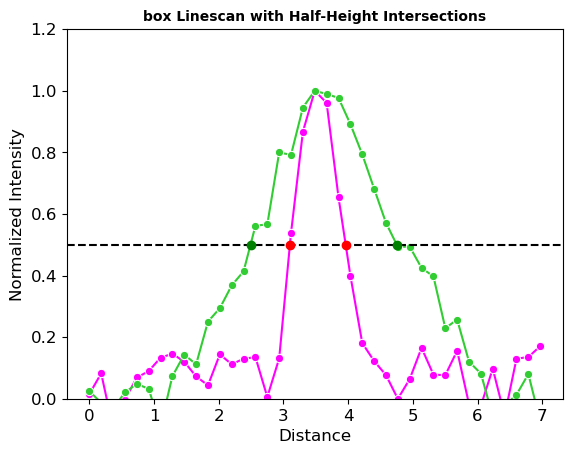

RFP Width at Half-Height: 0.8619180964262441
GFP Width at Half-Height: 2.2600515840706885


'2024-05-09 PoloGFP AslCherry_3_PP4KO_female_02_1-2_male_01_3-4 - Position 1 Image 3_nb7'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.6003077085706034
GFP Width at Half-Height: 2.540666967600989


'2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb1'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

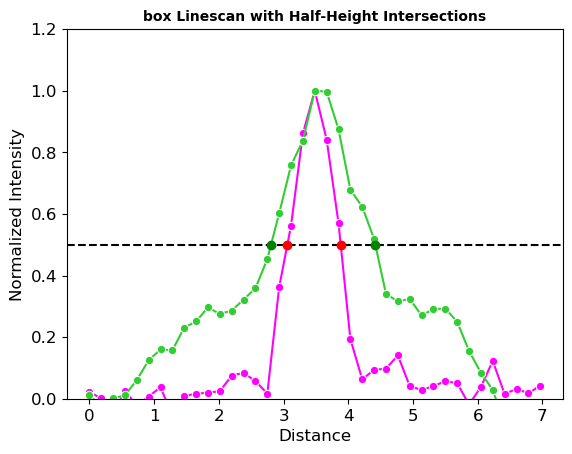

RFP Width at Half-Height: 0.8245113010078344
GFP Width at Half-Height: 1.6118977819338864


'2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb2'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.4, '−0.4'),
  Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.20000000000000007, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8000000000000002, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.7021457695422186
GFP Width at Half-Height: 1.670694737455936


'2024-05-09 PoloGFP AslCherry_4_PP4KO_female_02_1-2_male_01_3-4 - Position 2 Image 4_nb3'

<Axes: xlabel='distance', ylabel='normalized RFP'>

<Axes: xlabel='distance', ylabel='normalized RFP'>

Text(0.5, 1.0, 'box Linescan with Half-Height Intersections')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Normalized Intensity')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

(0.0, 1.2)

RFP Width at Half-Height: 0.6425582700405026
GFP Width at Half-Height: 2.090904486255734


In [15]:
def interpolate_half_height(x, y, half_height):
    # Interpolate between pairs of points around the half-height
    x_crossings = []
    for i in range(1, len(y)):
        y1, y2 = y.iloc[i - 1], y.iloc[i]
        if (y1 < half_height and y2 >= half_height) or (y1 >= half_height and y2 < half_height):
            x1, x2 = x.iloc[i - 1], x.iloc[i]
            # Linear interpolation formula
            x_cross = x1 + (half_height - y1) * (x2 - x1) / (y2 - y1)
            x_crossings.append(x_cross)
    return x_crossings

# Define the target half-height
half_height = 0.5

# addapting it into coded loops:
whh = pd.DataFrame(columns = ['file', 'genotype', 'GFP width', 'RFP width']) # empty frame 

for i in range(0, len(files)):
    pf = norm_data[(norm_data['file'] == files[i])].reset_index()
    files[i]
    # Replace 'pf' with your actual DataFrame and 'distance' and 'normalized RFP/GFP' with your column names.
    x = pf['distance']
    y_rfp = pf['normalized RFP']
    y_gfp = pf['normalized GFP']
    
    # Get the x-values where the curves cross the half-height
    rfp_crossings = interpolate_half_height(x, y_rfp, half_height)
    gfp_crossings = interpolate_half_height(x, y_gfp, half_height)
    
    # Calculate the width at half-height for each curve
    if len(rfp_crossings) >= 2:
        rfp_width = max(rfp_crossings) - min(rfp_crossings)
    else:
        rfp_width = np.nan
    
    if len(gfp_crossings) >= 2:
        gfp_width = max(gfp_crossings) - min(gfp_crossings)
    else:
        gfp_width = np.nan
    
    # Plotting (same as before)
    sns.lineplot(x='distance', y='normalized RFP', data=pf, color='magenta', marker='o')
    sns.lineplot(x='distance', y='normalized GFP', data=pf, color='limegreen', marker='o')
    plt.axhline(y=half_height, color='black', linestyle='--')
    plt.title(pf.loc[0, 'genotype'] + ' Linescan with Half-Height Intersections', fontsize=10, fontweight='bold')
    plt.xlabel('Distance', fontsize=12)
    plt.ylabel('Normalized Intensity', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 1.2)
    
    # Plot the crossing points for visualization
    for x_val in rfp_crossings:
        plt.plot(x_val, half_height, 'ro')  # Red dots for RFP
    for x_val in gfp_crossings:
        plt.plot(x_val, half_height, 'go')  # Green dots for GFP

    os.chdir(figs_dir + '/whh/')
    plt.savefig(files[i] + ' ' + pf.loc[0, 'genotype'] +' fit whh.svg', dpi = 600, bbox_inches = 'tight')
    plt.show();
    
    print(f'RFP Width at Half-Height: {rfp_width}');
    print(f'GFP Width at Half-Height: {gfp_width}');

    whh.loc[i, 'file'] = pf.loc[0, 'file']
    whh.loc[i, 'genotype'] = pf.loc[0, 'genotype']
    whh.loc[i, 'GFP width'] = gfp_width
    whh.loc[i, 'RFP width'] = rfp_width
    if whh.loc[i, 'genotype'] == 'box':
        whh.loc[i, 'genotype'] = 'WT'
        


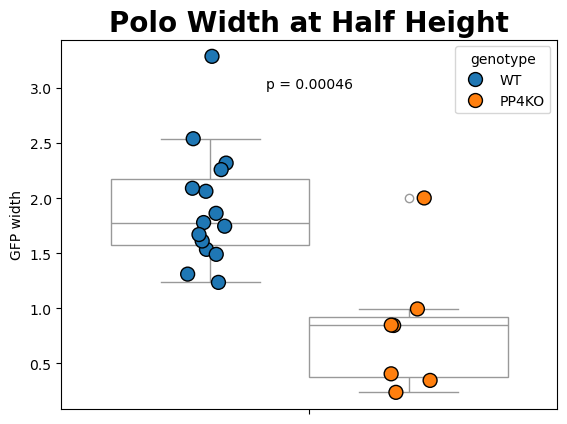

In [16]:
whh = whh[whh['GFP width'] < 3.5]

plt.title('Polo Width at Half Height', fontsize = 20, fontweight = 'bold')
#plt.ylim(0,0.6)


sns.stripplot(hue = 'genotype', y = 'GFP width', dodge = True, data = whh,
             hue_order = ['WT', 'PP4KO'], size = 10, edgecolor = 'k', linewidth = 1);

param1 = whh[whh['genotype']=='WT']['GFP width'].dropna()
param2 = whh[whh['genotype']=='PP4KO']['GFP width'].dropna()

pv = np.round(independent_ttest(param1, param2, 0.05)[3], decimals = 5)
plt.annotate(f"p = {pv}", xy = (0, 3), ha = 'center')

sns.boxplot(hue = 'genotype', y = 'GFP width', dodge = True, data = whh,
             hue_order = ['WT', 'PP4KO'], palette = ['w', 'w'], legend = False);

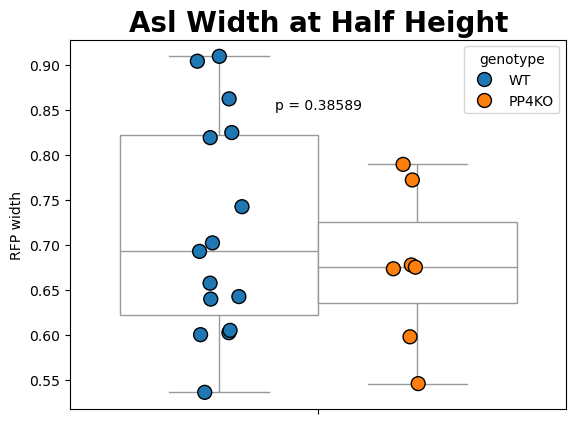

In [17]:
whh = whh[whh['GFP width'] < 3.5]

plt.title('Asl Width at Half Height', fontsize = 20, fontweight = 'bold')
#plt.ylim(0,0.6)


sns.stripplot(hue = 'genotype', y = 'RFP width', dodge = True, data = whh,
             hue_order = ['WT', 'PP4KO'], size = 10, edgecolor = 'k', linewidth = 1);

param1 = whh[whh['genotype']=='WT']['RFP width'].dropna()
param2 = whh[whh['genotype']=='PP4KO']['RFP width'].dropna()

pv = np.round(independent_ttest(param1, param2, 0.05)[3], decimals = 5)
plt.annotate(f"p = {pv}", xy = (0, 0.85), ha = 'center')

sns.boxplot(hue = 'genotype', y = 'RFP width', dodge = True, data = whh,
             hue_order = ['WT', 'PP4KO'], palette = ['w', 'w'], legend = False);

# Plot 5G: width at half height

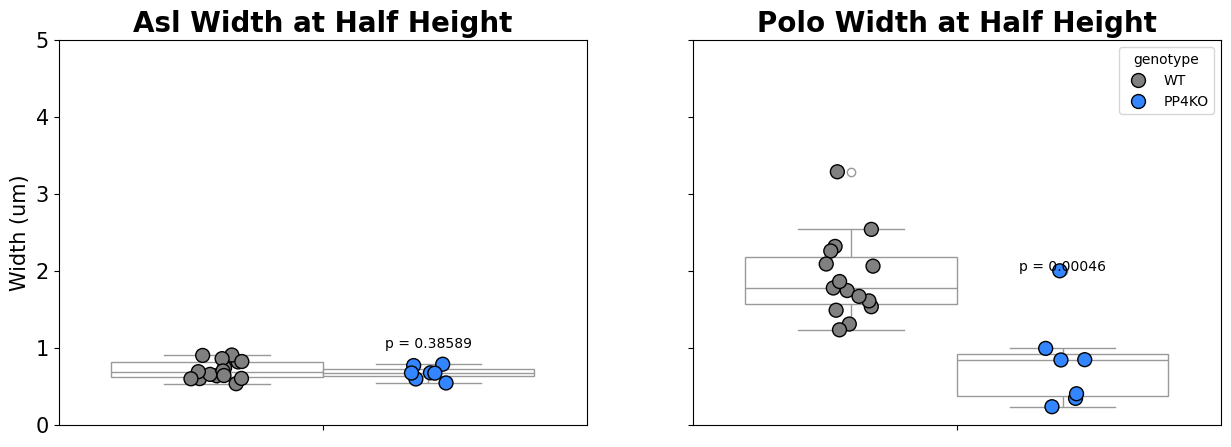

In [18]:
fig1, (ax1, ax2) = plt.subplots(ncols = 2,
                                                         nrows = 1,
                                                         sharex = True,
                                                         sharey = True,
                                                         figsize = (15,5))
p = ['grey', '#3386FF']
whh = whh[whh['GFP width'] < 3.5]

ax1.set_title('Asl Width at Half Height', fontsize = 20, fontweight = 'bold')
ax1.set_ylabel('Width (um)', fontsize = 15)
ax1.tick_params(labelsize = 15)
#plt.ylim(0,0.6)


sns.stripplot(hue = 'genotype', y = 'RFP width', dodge = True, data = whh,
             hue_order = ['WT', 'PP4KO'], size = 10, edgecolor = 'k', linewidth = 1, ax = ax1, palette = p,
             legend = False);

param1 = whh[whh['genotype']=='WT']['RFP width'].dropna()
param2 = whh[whh['genotype']=='PP4KO']['RFP width'].dropna()

pv = np.round(independent_ttest(param1, param2, 0.05)[3], decimals = 5)
ax1.annotate(f"p = {pv}", xy = (0.2, 1), ha = 'center')

sns.boxplot(hue = 'genotype', y = 'RFP width', dodge = True, data = whh,
             hue_order = ['WT', 'PP4KO'], palette = ['w', 'w'], legend = False, ax = ax1);


ax2.set_title('Polo Width at Half Height', fontsize = 20, fontweight = 'bold')
#plt.ylim(0,0.6)


sns.stripplot(hue = 'genotype', y = 'GFP width', dodge = True, data = whh,
             hue_order = ['WT', 'PP4KO'], size = 10, edgecolor = 'k', linewidth = 1, ax = ax2, palette = p);

param1 = whh[whh['genotype']=='WT']['GFP width'].dropna()
param2 = whh[whh['genotype']=='PP4KO']['GFP width'].dropna()

pv = np.round(independent_ttest(param1, param2, 0.05)[3], decimals = 5)
ax2.annotate(f"p = {pv}", xy = (0.2, 2), ha = 'center')

sns.boxplot(hue = 'genotype', y = 'GFP width', dodge = True, data = whh,
             hue_order = ['WT', 'PP4KO'], palette = ['w', 'w'], legend = False, ax = ax2)

ax2.set_ylim(0,5)
os.chdir(figs_dir)
plt.savefig('whh.svg', dpi = 600, bbox_inches = 'tight')
plt.show();

# Stats Table

In [19]:
stats_table = pd.DataFrame(columns = ['control variable', 'experimental variable', 'phase', 'marker', 'test', 'y-value',
                                      'control n', 'experimental n',
                                      'control mean', 'experimental mean',
                                     'control stdev', 'experimental stdev',
                                     'test statistic', 'degrees of freedom', 
                                     'critical value', 'p-value'])

pd.set_option('display.float_format', '{:.2E}'.format) # enables scientific notation

stats_table

Empty DataFrame
Columns: [control variable, experimental variable, phase, marker, test, y-value, control n, experimental n, control mean, experimental mean, control stdev, experimental stdev, test statistic, degrees of freedom, critical value, p-value]
Index: []

In [20]:
whh.head(5)

file genotype GFP width  \
0  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  1.31E+00   
1  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  1.54E+00   
2  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  2.32E+00   
3  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  1.78E+00   
4  2024-05-09 PoloGFP AslCherry_1_PP4KO_female_01...       WT  3.29E+00   

  RFP width  
0  7.42E-01  
1  5.36E-01  
2  6.02E-01  
3  6.05E-01  
4  9.04E-01

In [21]:
# test# = [control genotype, experimental genotype, y-value]
t1 = ['WT', 'PP4KO', 'GFP width']
t2 = ['WT', 'PP4KO', 'RFP width']

tests = [t1, t2]

In [22]:
data = whh
for i in range(0, len(tests)):
    stats_table.loc[i, 'control variable'] = tests[i][0]
    stats_table.loc[i, 'experimental variable'] = tests[i][1]
    stats_table.loc[i, 'y-value'] = tests[i][2]
    
    param1 = data[(data['genotype']==tests[i][0])][tests[i][2]].dropna()
    param2 = data[(data['genotype']==tests[i][1])][tests[i][2]].dropna()

    stats_table.loc[i, 'control n'] = len(param1)
    stats_table.loc[i, 'experimental n'] = len(param2)

    stats_table.loc[i, 'control mean'] = param1.mean()
    stats_table.loc[i, 'experimental mean'] = param2.mean()

    stats_table.loc[i, 'control stdev'] = param1.std()
    stats_table.loc[i, 'experimental stdev'] = param2.std()

    test = independent_ttest(param1, param2, 0.05)
    stats_table.loc[i, 'test statistic'] = test[0]
    stats_table.loc[i, 'degrees of freedom'] = test[1]
    stats_table.loc[i, 'critical value'] = test[2]
    stats_table.loc[i, 'p-value'] = test[3]


    if test[3] < 0.0001:
        sig = "****"
    elif test[3] < 0.001:
        sig = "***"
    elif test[3] < 0.01:
        sig = "**"
    elif test[3] < 0.05:
        sig = "*"
    elif test[3] > 0.05:
        sig = "ns"
    stats_table.loc[i, 'significance'] = sig
    
stats_table['test'] = "Unpaired Student's T-test"
stats_table

control variable experimental variable phase marker  \
0               WT                 PP4KO   NaN    NaN   
1               WT                 PP4KO   NaN    NaN   

                        test    y-value control n experimental n control mean  \
0  Unpaired Student's T-test  GFP width        15              7     1.92E+00   
1  Unpaired Student's T-test  RFP width        15              7     7.16E-01   

  experimental mean control stdev experimental stdev test statistic  \
0          8.11E-01      5.32E-01           6.01E-01       4.18E+00   
1          6.76E-01      1.20E-01           8.66E-02       8.86E-01   

  degrees of freedom critical value  p-value significance  
0                 20       1.72E+00 4.63E-04          ***  
1                 20       1.72E+00 3.86E-01           ns

In [23]:
# saving output
os.chdir(outs_dir)
stats_table.to_csv('whh stats.csv')